<a href="https://colab.research.google.com/github/arao53/awh-limits/blob/main/lego_maps/warsinger_lego_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstructing map-data with legos

**Background**
This notebook demonstrates a process to create lego-compatible color codes and instructions from a raster data. In this example, we show the use for maps where the color represents the minimum energy requirements needed to harvest water from the air. More information about the specific example can be found in the paper: https://doi.org/10.1039/D2EE01071B

**Notebook contents**
1. *Imports and helper functions*: primary data-processing functions that were useful in translating the published data into a format that can then be built into a lego-map. 

2. *Code example*: A concrete example (with images) of each step of the work-flow.

**Process overview**
The workflow follows a simple 3 step process: image reshaping, color binning, and color asssignment. 
a. In the first step, the original data is reshaped from the original resolution to an aspect ratio that can be made from Legos. In this example, we use 60x90 output resolution.
b. We bin the data values into a number of bins corresponding to the number of unique lego colors that we plan to use. In this example, we start with 30 colors and geometric spacing. [Lisa Charlotte Muth wrote a fantastic article](https://blog.datawrapper.de/interpolation-for-color-scales-and-maps/) on a more robust way of binning colors based on the data's frequency distributions. 
c. Lastly, we create a color key by assigning bin values to specific colors. In this example, we show a way to fit the bins to Matplotlib's colormaps based on the mean squared error in r-g-b space. Instead, one can also manually pick the colors to associate with bins ($n< 30$). 

We hope other GIS researchers and scientists alike can enjoy this fun way of sharing research results!

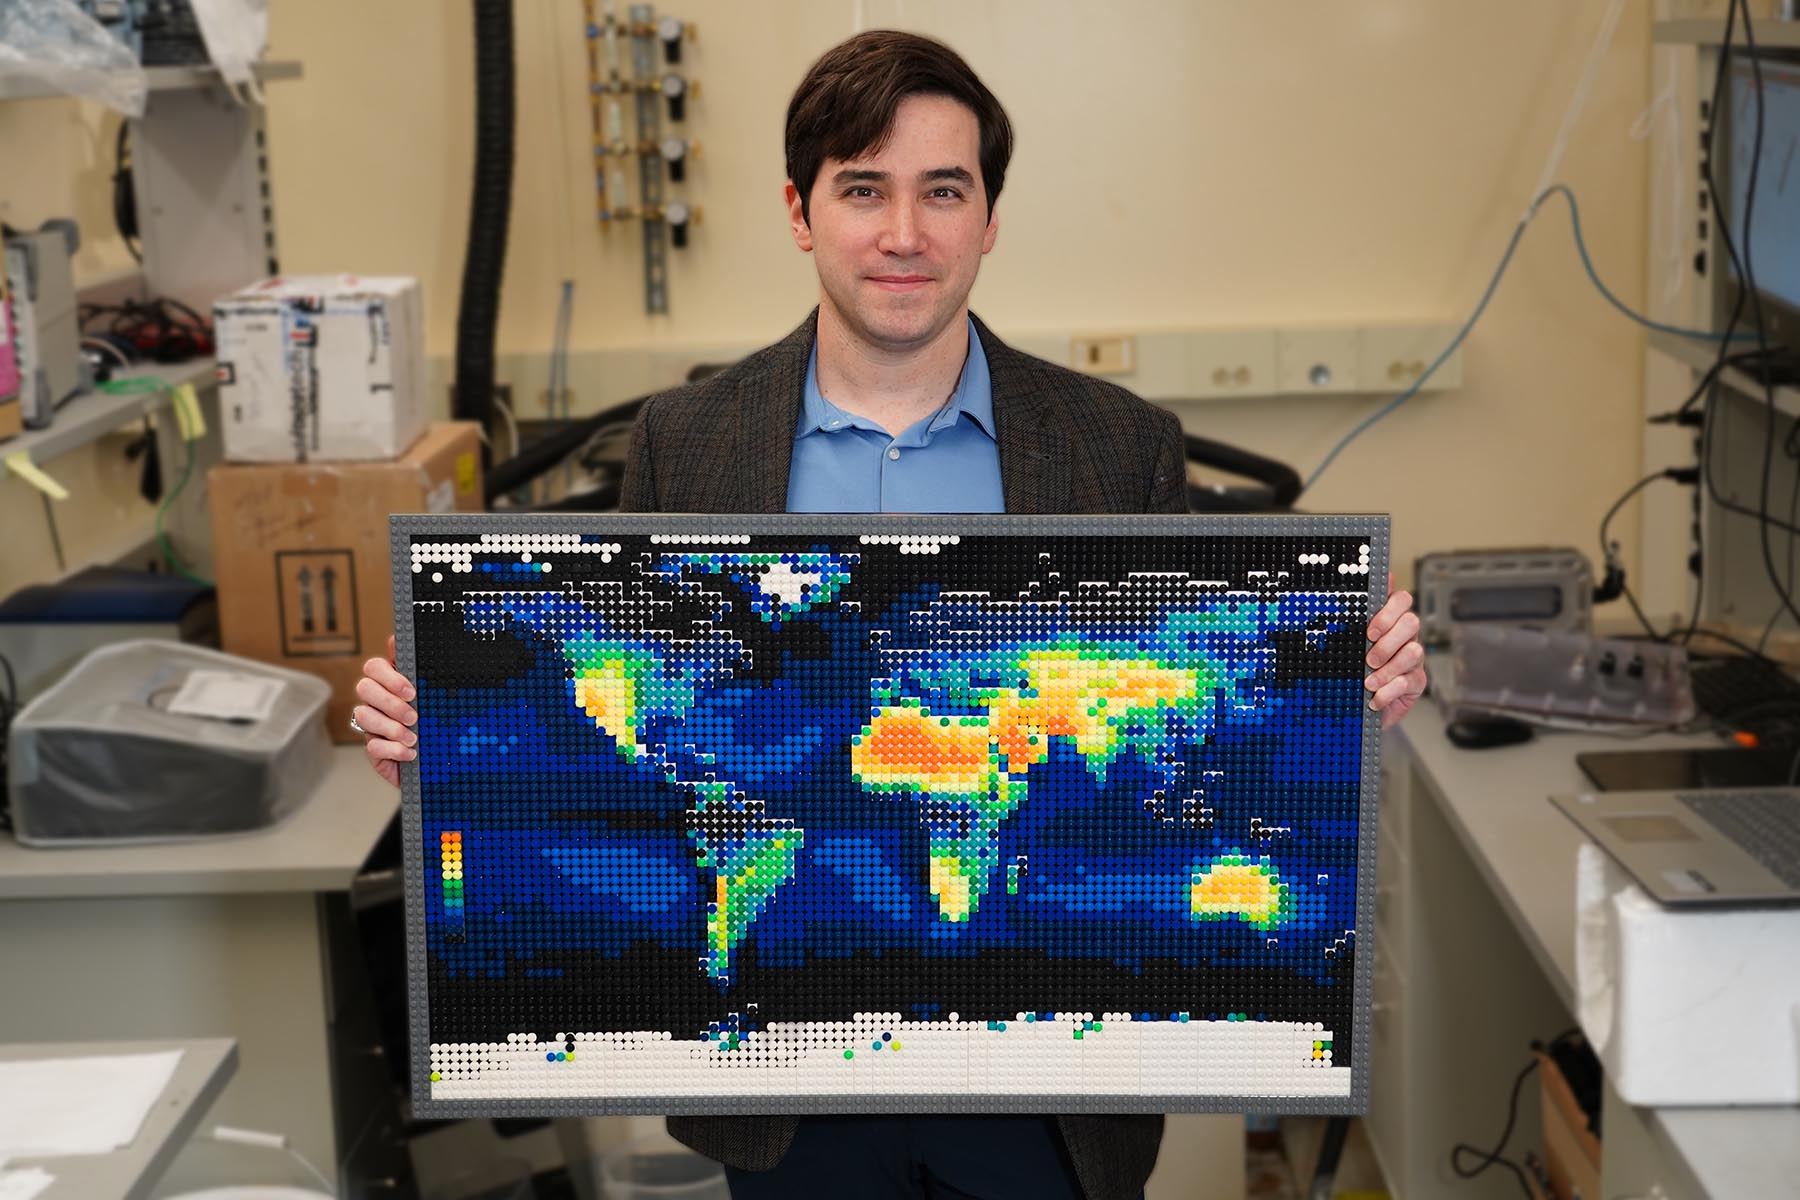

### 1. Imports and helper functions

First, we need to import a few commonly used python libraries. We use numpy and pandas for data processing and basic math operations, matplotlib for plotting the maps, and h5py to access the original raster dataset.



In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from time import sleep

## Mount google drive to run on Colab
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/WaterHarvesting/AWH research/"

# Access data - we will be using the mean energy requirements from the file: '2021_hourly.h5'
import h5py
f = h5py.File('2021_hourly.h5', 'r')
mean = f['mean'][:]
print("The resolution of the image is: ", mean.shape)

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/WaterHarvesting/AWH research
The resolution of the image is:  (361, 576)


In [2]:
class build_map():
  def __init__(self, original_data, desired_size, available_colors_csv):
    self.original_map = original_data
    self.map = original_data
    self.desired_size = desired_size,
    self.n = 0  # place holder
    self.color_df = pd.read_csv(available_colors_csv)

  def downsize_map(self, data):
    shape = data.shape
    r = np.divide(shape, self.desired_size).astype(int)[0]
    downsized_map = data[::r[0], ::r[1]]
    return downsized_map

  def recolor_map(self, data):
    min_d = np.nanmin(data)
    max_d = np.nanmax(data)

    bins = np.geomspace(min_d, max_d*1.1, self.n)

    recolored_data = np.nan_to_num(data, nan=max_d*2)
    return np.digitize(recolored_data, bins), bins, self.n
  
  def color_picker(self, picked_colors, sorted_color_row):
    for idx, color in enumerate(sorted_color_row):
      if color not in picked_colors:
        return color, idx
  
  def evaluate_color_scheme(self, cmap):
    
    # reshape the available color dataset
    col_labels = self.color_df.columns.values
    color_df = self.color_df.drop(columns=col_labels[1:-3])
    color_arr = color_df.to_numpy()
    
    
    # get the color map from maplotlib and normalize it to the clean data
    cm = plt.pcolormesh(self.map, cmap=cmap)
    color_scheme = cmap(cm.norm(range(self.n)))
    color_scheme = color_scheme.astype(int)

    # initialize a bunch of containers
    temp_score = np.ndarray(shape=color_arr.shape[0])
    score_matrix = np.ndarray(shape= [self.n, color_arr.shape[0]])
    color_idx = np.ndarray(self.n)
    chosen_color = np.array([])
    colors = color_arr[:,0]
    scheme_score = np.array([])

    # loop through each color level 
    for i in range(self.n): 
      r,g,b = color_scheme[i,:3]

      # loop through each color available from LEGO
      for j in range(color_arr.shape[0]):
        lego_color = color_arr[j,:]

        # find the 2norm in rgb space between the matplotlib color and each LEGO color
        temp = np.sqrt((int(r)-lego_color[1]/255)**2 + (int(g)-lego_color[2]/255)**2 + (int(b)-lego_color[3]/255)**2)
        temp_score[j] = temp
      
      # for the first level, assign the closest color
      if i == 0:
        score_as = np.argsort(temp_score)
        sorted_color_row = colors[score_as[::1]]
        chosen_color = np.append(chosen_color, sorted_color_row[0])
        scheme_score = np.append(scheme_score, np.min(temp_score))
      
      # for every subsequent level, choose the closest color that hasn't been picked yet
      else:  
        score_as = np.argsort(score_matrix[i,:])
        sorted_color_row = colors[score_as[::1]]
        unique_color, idx = self.color_picker(chosen_color, sorted_color_row)
        chosen_color = np.append(chosen_color, unique_color)
        scheme_score = np.append(scheme_score, np.sort(temp_score)[idx])
    
    return chosen_color, scheme_score

  def build_LEGO(self, mpl_colorscheme, num_colors=7):

    self.n = num_colors

    # downsize the map
    self.map = self.downsize_map(self.original_map)

    # bin colors against the matplotlib spectrum
    self.map, bins, _ = self.recolor_map(self.map)

    # find a set of LEGO colors for the mpl color spectrum and evaluate its fitness
    color_set, scheme_score = self.evaluate_color_scheme(mpl_colorscheme)

    print("LEGO Color IDs: ", color_set)
    print("The energy bins are: ,", bins, 'kJ/kg')
    print("The colorscheme fitness to matplotlib is: ", np.sum(scheme_score))
    print("The worst fitting color is: ", color_set[np.argmax(scheme_score)])
    return color_set, scheme_score
  def save_map(self, path):
    pd.DataFrame(self.map).to_csv(path)
    print("saved to: ", path)
    return


## 2. Code example

[6 6]
LEGO Color IDs:  [ 26. 133. 118. 224. 137.  45. 330. 308.   7. 101. 232.  19. 104. 223.
  37.   1. 125. 222. 193. 269.  23. 213.   5. 102. 128. 199. 151. 208.
 322.  18.]
The energy bins are: , [  3.65526377   4.26130849   4.96783576   5.79150564   6.75174043
   7.87118267   9.17622904  10.69765281  12.47132948  14.5390827
  16.94967053  19.75993513  23.03614314  26.85554822  31.30821274
  36.49913146  42.55070733  49.60563778  57.83027954  67.41857139
  78.59660724  91.62796753 106.81993445 124.53073776 145.1780019
 169.24859368 197.31010269 230.02422518 268.16236699 312.62383348] kJ/kg
The colorscheme fitness to matplotlib is:  7.625984495961203
The worst fitting color is:  102.0
saved to:  warsinger_lego_maps/30_bins_60by96.csv


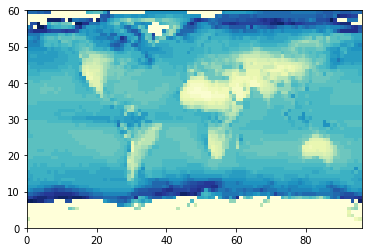

In [6]:
lego_colors_csv = "warsinger_lego_maps/lego_color_palette.csv"
cmap = plt.cm.YlGnBu_r
lego_map_size = np.array([60,96]) # units n pieces x n pieces

mean_clipped = mean[1:, :]
data_shape = mean.shape

bm = build_map(mean_clipped, desired_size = lego_map_size, available_colors_csv = lego_colors_csv)
a,b = bm.build_LEGO(cmap, num_colors=30)
bm.save_map("warsinger_lego_maps/30_bins_60by96.csv")

In [ ]:
bm.map.shape

(60, 96)

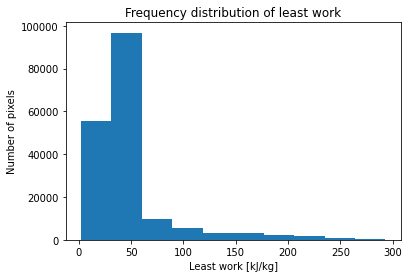

In [ ]:
fig2, ax = plt.subplots()
ax.hist(np.ravel(mean_clipped))
ax.set_xlabel("Least work [kJ/kg]")
ax.set_ylabel("Number of pixels")
ax.set_title("Frequency distribution of least work");

In [ ]:
save_path = "warsinger_lego_maps/" + cmap.name + ".csv"
# bm.save_map(save_path)

In [ ]:
# display pixels with land versus water
!pip install global-land-mask
from global_land_mask import globe

shape = bm.map.shape
lat = np.linspace(-90, 90, 60, endpoint=False)
long = np.linspace(-180, 180, 96, endpoint=False)
latitudes = np.zeros(shape=[60,96])
longitudes = np.zeros(shape=[60,96])

for i in range(95,-1,-1):
  latitudes[:,i] = lat

for j in range(59,-1,-1):
  longitudes[j][:] = long.T


landmask = globe.is_land(np.asmatrix(latitudes), np.asmatrix(longitudes))
landmask = np.asmatrix(landmask).astype(int)
fig, ax = plt.subplots()
ax.contourf(landmask, cmap="Greys")
# pd.DataFrame(landmask).to_csv("warsinger_lego_maps/landmask")